In [1]:
from matplotlib import pyplot as plt

import torch
from torch import nn
from torch import optim

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#Fix random seeds for reproducibility
import numpy as np
import random

random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.use_deterministic_algorithms(True)

In [2]:
class OscillatoryGridCell1D(nn.Module):
    def __init__(self, *args, randomize=True, dtype=torch.float32, device="cpu", **kwargs):
        super().__init__(*args, **kwargs)

        self.device = device
        self.dtype = dtype

        self.shift = self._init_param(0, lambda x: nn.init.uniform_(x, 0, 1) if randomize else x)
        self.scaling = self._init_param(1, lambda x: nn.init.trunc_normal_(x, 1, 1.0, 0.1, 10) if randomize else x)

    def forward(self, position):
        """Encode a point on a cartesian 1D axis to a grid cell activation."""
        # We scale only the coordinates to keep the shift in the [0, 1] range
        position = self.scaling * position - self.shift
        return (torch.cos(2 * torch.pi * position) + 1) / 2
    
    def _init_param(self, default_value, init_function):
        param = torch.tensor(default_value, dtype=self.dtype, device=self.device)
        init_function(param)
        param = nn.Parameter(param, requires_grad=True)
        return param

In [3]:
class GridCellArray1D(nn.Module):
    def __init__(self, n_neurons, *args, dtype=torch.float32, device="cpu", **kwargs):
        super().__init__(*args, **kwargs)

        self.device = device
        self.dtype = dtype

        assert n_neurons > 0, "Number of neurons must be positive."
        self.neurons = nn.ModuleList([OscillatoryGridCell1D(dtype=dtype, device=device) for _ in range(n_neurons)])

    def forward(self, X):
        """Encode a point on a cartesian 2D plane to a vector of grid cell neuron activations."""
        return torch.stack([cell(X) for cell in self.neurons], dim=-1).squeeze(dim=0)

In [4]:
grid_cell = OscillatoryGridCell1D(randomize=False, dtype=torch.float32, device=device)

In [5]:
grid_cell(0)

tensor(1., grad_fn=<DivBackward0>)

In [6]:
positions = torch.tensor([-1, -0.75, -0.5, -0.25, 0, 0.25, 0.5, 0.75, 1], dtype=torch.float32, device=device)

grid_cell(positions)

tensor([1.0000, 0.5000, 0.0000, 0.5000, 1.0000, 0.5000, 0.0000, 0.5000, 1.0000],
       grad_fn=<DivBackward0>)

In [7]:
N = 1001
x_min, x_max = -1, 1

positions = torch.linspace(x_min, x_max, N, dtype=torch.float32, device=device)

In [8]:
randomized_grid_cell = OscillatoryGridCell1D(randomize=True, dtype=torch.float32, device=device)

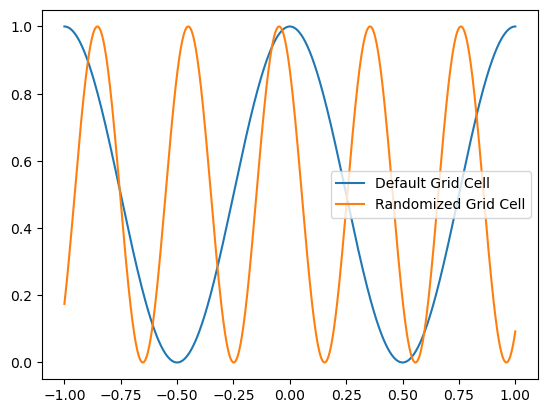

In [9]:
plt.plot(positions, grid_cell(positions).detach().numpy(), label="Default Grid Cell")
plt.plot(positions, randomized_grid_cell(positions).detach().numpy(), label="Randomized Grid Cell")
plt.legend()

In [10]:
grid_cell_array = GridCellArray1D(5, dtype=torch.float32, device=device)

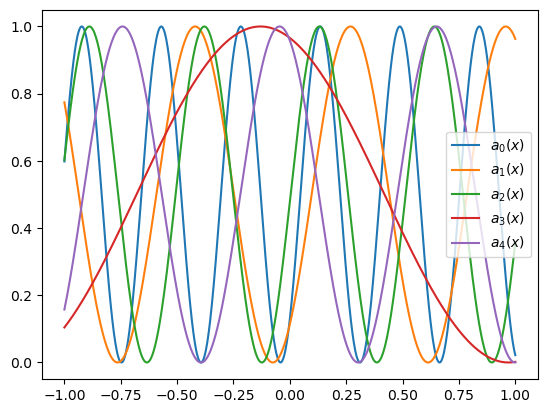

In [11]:
for i, neuron in enumerate(grid_cell_array.neurons):
    plt.plot(positions, neuron(positions).detach().numpy(), label=f"$a_{i}(x)$")

plt.legend()

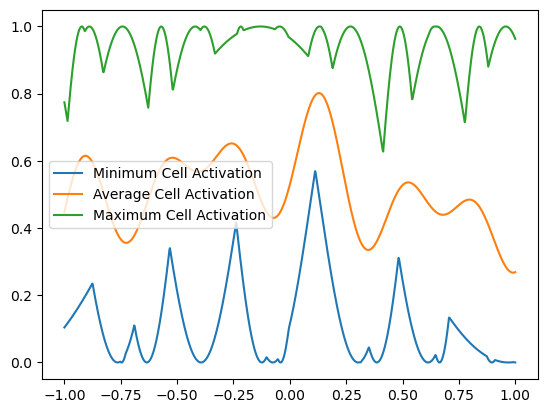

In [12]:
plt.plot(positions, grid_cell_array(positions).min(axis=-1).values.detach().numpy(), label="Minimum Cell Activation")
plt.plot(positions, grid_cell_array(positions).mean(axis=-1).detach().numpy(), label="Average Cell Activation")
plt.plot(positions, grid_cell_array(positions).max(axis=-1).values.detach().numpy(), label="Maximum Cell Activation")

plt.legend()

In [13]:
class LinearDecoder1D(nn.Module):
    def __init__(self, grid_cell_array, *args, weighted=True, weight_normalization=None, probability_normalization=None, dtype=torch.float32, device="cpu", **kwargs):
        super().__init__(*args, **kwargs)

        self.device = device
        self.dtype = dtype

        self.n_neurons = len(grid_cell_array.neurons)
        
        self.grid_cell_array = grid_cell_array

        # We don't need need bias because we will be inferring the predicted position from the maximum activation value
        weights_ = torch.ones(self.n_neurons, dtype=dtype, device=device)
        if weighted:
            nn.init.normal_(weights_, 0, 1)
        self.weights_ = nn.Parameter(weights_, requires_grad=weighted)
        if weight_normalization is None:
            self.normalize_weights = lambda x: x
        elif weight_normalization == "softmax":
            self.normalize_weights = nn.Softmax(dim=-1)
        elif weight_normalization == "linear":
            self.normalize_weights = lambda x: x / torch.sum(x)
        elif weight_normalization == "squared":
            # The squared normalization is useful to enforce the weights to be positive
            self.normalize_weights = lambda x: x ** 2 / torch.sum(x ** 2)
        else:
            raise ValueError("Invalid weight normalization method.")
        
        if probability_normalization is None:
            self.normalize_probabilities = lambda x: x
        elif probability_normalization == "softmax":
            self.normalize_probabilities = nn.Softmax(dim=-1)
        elif probability_normalization == "linear":
            self.normalize_probabilities = lambda x: x / torch.sum(x)
        elif probability_normalization == "squared":
            self.normalize_probabilities = lambda x: x ** 2 / torch.sum(x ** 2)
        else:
            raise ValueError("Invalid probability normalization method.")
    
    def forward(self, true_activations, position_estimates):
        """Decode the neuron representation"""
        assert (true_activations.shape[-1] == self.n_neurons), "The number of neurons in the grid cell array must match the number of neurons used the true activations."
        assert len(true_activations.shape) <= 2, "The true activations must be a tensor of shape (n_true_positions, n_neurons)."
        if len(true_activations.shape) == 1:
            true_activations = true_activations.reshape(1, self.n_neurons)

        # 1. Compute the activation for possible X estimations
        estimated_activations = self.grid_cell_array(position_estimates)

        # 2. Multiply it by the activations for the true positions (it will discriminate against the other positions)
        # TODO: Optimize this step using better vectorization technique
        if len(estimated_activations.shape) == 1:
            estimated_activations = estimated_activations.reshape(1, -1)
        discriminated_activations = (estimated_activations.expand(true_activations.shape[0], -1, -1).transpose(0, 1) * true_activations).transpose(0, 1)
        # 3. Compute the weighted sum using the decoder weights (the decoder will consider some neurons more "valuable" than others)
        decoded_activations = discriminated_activations @ self.weights()
        # Apply softmax to get the position probability distribution estimate
        position_probabilities = self.normalize_probabilities(decoded_activations.reshape(true_activations.shape[0], -1))
        # 4. Find the position expectations by computing the weighted sum of the position estimations' probabilities
        position_expectations = (position_probabilities @ position_estimates) / position_probabilities.sum(dim=-1)
        most_probable_positions = position_estimates[position_probabilities.argmax(dim=-1)]
        return position_probabilities, position_expectations, most_probable_positions
    
    def weights(self):
        # Note that we may use the normalization to force the weights to sum up to 1
        return self.normalize_weights(self.weights_)

In [14]:
decoder = LinearDecoder1D(grid_cell_array, dtype=torch.float32, device=device, weighted=True, weight_normalization=None, probability_normalization=None)
decoder.weights()

Parameter containing:
tensor([ 2.2082, -0.6380,  0.4617,  0.2674,  0.5349], requires_grad=True)

In [15]:
decoder = LinearDecoder1D(grid_cell_array, dtype=torch.float32, device=device, weighted=True, weight_normalization="softmax", probability_normalization=None)
decoder.weights()

tensor([0.2660, 0.3594, 0.0219, 0.0440, 0.3086], grad_fn=<SoftmaxBackward0>)

In [16]:
decoder = LinearDecoder1D(grid_cell_array, dtype=torch.float32, device=device, weighted=True, weight_normalization="linear", probability_normalization=None)
decoder.weights()

tensor([ 0.6693,  0.4137, -0.3877, -0.3800,  0.6847], grad_fn=<DivBackward0>)

In [17]:
decoder = LinearDecoder1D(grid_cell_array, dtype=torch.float32, device=device, weighted=True, weight_normalization="squared", probability_normalization=None)
decoder.weights()

tensor([0.3643, 0.0831, 0.4888, 0.0613, 0.0024], grad_fn=<DivBackward0>)

In [18]:
decoder = LinearDecoder1D(grid_cell_array, dtype=torch.float32, device=device, weighted=False, weight_normalization="linear", probability_normalization=None)
decoder.weights()

tensor([0.2000, 0.2000, 0.2000, 0.2000, 0.2000])

In [19]:
true_x = torch.tensor([0.5], dtype=torch.float32, device=device)
true_activations = grid_cell_array(true_x)
true_activations

tensor([0.9880, 0.2440, 0.4178, 0.3863, 0.6033], grad_fn=<SqueezeBackward1>)

In [20]:
positions = torch.tensor([0.5], dtype=torch.float32, device=device)

position_probabilities, position_expectations, most_probable_positions = decoder(true_activations, positions)

print((true_activations.reshape(1, -1) ** 2).mean(dim=-1))

position_probabilities, position_expectations, most_probable_positions

tensor([0.3447], grad_fn=<MeanBackward1>)


(tensor([[0.3447]], grad_fn=<ReshapeAliasBackward0>),
 tensor([0.5000], grad_fn=<DivBackward0>),
 tensor([0.5000]))

In [21]:
decoder = LinearDecoder1D(grid_cell_array, dtype=torch.float32, device=device, weighted=True, weight_normalization="squared", probability_normalization=None)
decoder.weights()

tensor([4.4819e-01, 9.3193e-02, 4.0849e-03, 4.5442e-01, 1.1848e-04],
       grad_fn=<DivBackward0>)

In [22]:
positions = torch.tensor([-1, -0.75, -0.5, -0.25, 0, 0.25, 0.5, 0.75, 1], dtype=torch.float32, device=device)

decoder(true_activations, positions)

(tensor([[0.3019, 0.0717, 0.4425, 0.5899, 0.2303, 0.2718, 0.5116, 0.2385, 0.0325]],
        grad_fn=<ReshapeAliasBackward0>),
 tensor([-0.0703], grad_fn=<DivBackward0>),
 tensor([-0.2500]))

In [23]:
true_x = torch.tensor([0, 0.5, 1, 10], dtype=torch.float32, device=device)
true_activations = grid_cell_array(true_x)
true_activations

tensor([[1.2942e-01, 1.1385e-01, 4.7936e-01, 9.6578e-01, 9.5837e-01],
        [9.8798e-01, 2.4403e-01, 4.1784e-01, 3.8628e-01, 6.0334e-01],
        [2.1832e-02, 9.6311e-01, 3.5758e-01, 1.8803e-03, 7.3314e-06],
        [9.9320e-01, 8.4399e-01, 2.0752e-01, 1.0495e-01, 6.1855e-02]],
       grad_fn=<SqueezeBackward1>)

In [24]:
positions = torch.tensor([-1, -0.75, -0.5, -0.25, 0, 0.25, 0.5, 0.75, 1], dtype=torch.float32, device=device)

decoder(true_activations, positions)

(tensor([[0.0899, 0.1771, 0.3759, 0.4859, 0.4336, 0.3489, 0.2303, 0.0746, 0.0130],
         [0.3019, 0.0717, 0.4425, 0.5899, 0.2303, 0.2718, 0.5116, 0.2385, 0.0325],
         [0.0763, 0.0014, 0.0861, 0.0564, 0.0130, 0.0932, 0.0325, 0.0363, 0.0872],
         [0.3327, 0.0202, 0.3969, 0.4961, 0.1130, 0.2337, 0.4778, 0.2459, 0.0859]],
        grad_fn=<ReshapeAliasBackward0>),
 tensor([-0.1170, -0.0703,  0.0403, -0.0428], grad_fn=<DivBackward0>),
 tensor([-0.2500, -0.2500,  0.2500, -0.2500]))

In [25]:
grid_cell_array = GridCellArray1D(5, dtype=torch.float32, device=device)
decoder = LinearDecoder1D(grid_cell_array, dtype=torch.float32, device=device, weighted=True)

N = 1001
x_min, x_max = -1, 1

positions = torch.linspace(x_min, x_max, N, dtype=torch.float32, device=device)

true_positions = torch.tensor([0, 0.5, 1, -1, -0.5], dtype=torch.float32, device=device)

true_activations = grid_cell_array(true_positions)
position_probabilities, position_expectations, most_probable_positions = decoder(true_activations, positions)
print(position_probabilities.shape)
print(position_expectations)
print(most_probable_positions)

torch.Size([5, 1001])
tensor([-0.0875,  0.8030, -0.0169,  0.0467,  0.0167], grad_fn=<DivBackward0>)
tensor([-0.3260, -0.3360, -0.3240, -0.2980, -0.3260])


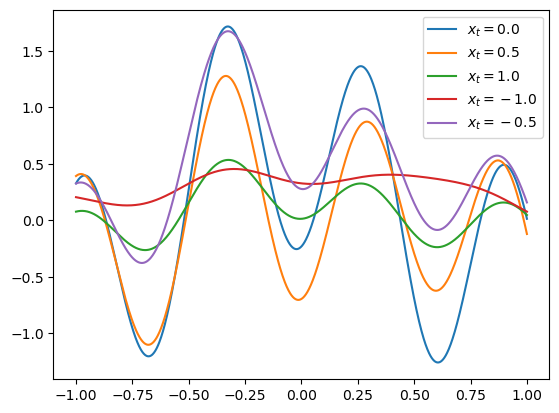

In [26]:
for i, true_position in enumerate(true_positions):
    plt.plot(positions, position_probabilities[i].detach().numpy(), label=f"$x_t={true_position}$")

plt.legend()

In [27]:
def train(*,
    n_neurons=5,
    weighted_decoder=True,
    weight_normalization=None,
    probability_normalization="softmax",
    # Training Domain
    x_min=-1,
    x_max=1,
    n_positions=1000,
    # Validation Domain
    x_val_min=1,
    x_val_max=3,
    n_val_positions=100,
    # Training Parameters
    n_epochs=100,
    batch_size=100,
    optimizer="adam",
    learning_rate=0.01,
    losses=None,

    random_seed=None,
    verbose=True,
    dtype=torch.float32,
    device="cpu",
):
    if random_seed is not None:
        random.seed(random_seed)
        np.random.seed(random_seed)
        torch.manual_seed(random_seed)
        torch.use_deterministic_algorithms(True)
        
    if losses is None:
        losses = ["mse", "variance", "negative_log_probability", "decoder_weight_regularization"]
    else:
        for loss in losses:
            if loss not in ["mse", "variance", "negative_log_probability", "decoder_weight_regularization"]:
                raise ValueError("Invalid loss function.")

    # Define the training domain  
    positions = torch.empty(n_positions, dtype=dtype, device=device)
    positions = torch.linspace(x_min, x_max, n_positions)
    #torch.nn.init.uniform_(positions, -1, 1)

    # Define the validation domain
    val_positions = torch.empty(n_val_positions, dtype=dtype, device=device)
    val_positions = torch.linspace(x_val_min, x_val_max, n_val_positions)

    # Define the grid cell array and the decoder
    grid_cell_array = GridCellArray1D(n_neurons, dtype=dtype, device=device)
    decoder = LinearDecoder1D(
        grid_cell_array,
        weighted=weighted_decoder,
        weight_normalization=weight_normalization,
        probability_normalization=probability_normalization,
        dtype=dtype,
        device=device,
    )

    # Define the optimizer
    if optimizer == "adam":
        optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
    elif optimizer == "sgd":
        optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    else:
        raise ValueError("Invalid optimizer.")
    
    for epoch in range(n_epochs):
        # Generate random positions for the epoch
        # TODO: Use DataSet and DataLoader
        positions = positions[torch.randperm(n_positions, device=device)]
        for i in range(0, n_positions, batch_size):
            optimizer.zero_grad()

            batch_positions = positions[i:i + batch_size]
            true_activations = grid_cell_array(batch_positions)
            position_probabilities, position_expectations, _ = decoder(true_activations, batch_positions)

            loss = 0


            if "mse" in losses:
                loss += ((position_expectations - batch_positions) ** 2).mean()
            
            # Variance (not the best but adds stability)
            if "variance" in losses:
                loss += (((batch_positions.expand(batch_size, -1).T - batch_positions) ** 2).sum(dim=-1) * position_probabilities).mean()

            # Negative log probability for true positions: 
            if "negative_log_probability" in losses:
                loss -= torch.log(position_probabilities.diagonal()).sum()

            # Regularize agaist decoder weight difference:
            if "decoder_weight_regularization" in losses:
                loss += (decoder.weights() ** 2).mean()            
            loss.backward()
            optimizer.step()

        if verbose:
            true_activations = grid_cell_array(positions)
            _, _, most_probable_positions = decoder(true_activations, positions)
            loss = ((most_probable_positions - positions) ** 2).mean()

            val_true_activations = grid_cell_array(val_positions)
            _, _, val_most_probable_positions = decoder(val_true_activations, val_positions)
            val_loss = ((val_most_probable_positions - val_positions) ** 2).mean()

            print(f"Epoch {epoch + 1}: Loss: {loss.item()}, Validation Loss: {val_loss.item()}")
        

    return grid_cell_array, decoder

In [28]:
grid_cell_array, decoder = train(
    n_neurons=10,
    weighted_decoder=True,
    weight_normalization=None,
    probability_normalization="softmax",
    # Training Domain
    x_min=-1,
    x_max=1,
    n_positions=1000,
    # Validation Domain
    x_val_min=1,
    x_val_max=3,
    n_val_positions=100,
    # Training Parameters
    n_epochs=1000,
    batch_size=100,
    optimizer="adam",
    learning_rate=0.001,
    losses=["variance", "negative_log_probability", "decoder_weight_regularization"],

    random_seed=33,
    verbose=True,
    dtype=torch.float32,
    device="cpu",
)


Epoch 1: Loss: 0.6118469834327698, Validation Loss: 0.7218284010887146
Epoch 2: Loss: 0.5835289359092712, Validation Loss: 0.80353844165802
Epoch 3: Loss: 0.5662480592727661, Validation Loss: 0.7383246421813965
Epoch 4: Loss: 0.5418339371681213, Validation Loss: 0.6838160157203674
Epoch 5: Loss: 0.5010337233543396, Validation Loss: 0.6123824119567871
Epoch 6: Loss: 0.4521297514438629, Validation Loss: 0.4404326379299164
Epoch 7: Loss: 0.411164790391922, Validation Loss: 0.42129984498023987
Epoch 8: Loss: 0.37540963292121887, Validation Loss: 0.45521068572998047
Epoch 9: Loss: 0.35780930519104004, Validation Loss: 0.6310253739356995
Epoch 10: Loss: 0.34500208497047424, Validation Loss: 0.6279481649398804
Epoch 11: Loss: 0.48128870129585266, Validation Loss: 0.6132965683937073
Epoch 12: Loss: 0.4752408266067505, Validation Loss: 0.623907744884491
Epoch 13: Loss: 0.4424511790275574, Validation Loss: 0.6278665065765381
Epoch 14: Loss: 0.43685418367385864, Validation Loss: 0.962318241596221

In [29]:
decoder.weights()

Parameter containing:
tensor([5.7677e+00, 5.4014e+00, 6.4207e+00, 4.0609e-05, 5.3990e+00, 6.5820e+00,
        5.9771e+00, 6.0795e+00, 6.7749e+00, 5.5155e+00], requires_grad=True)

torch.Size([5, 1001])
tensor([-1.0000, -0.5000,  0.0000,  0.5000,  1.0000])
tensor([-0.3914, -0.4415,  0.0052,  0.4570,  0.5832], grad_fn=<DivBackward0>)
tensor([-0.9740, -0.4960,  0.0000,  0.4980,  0.9780])


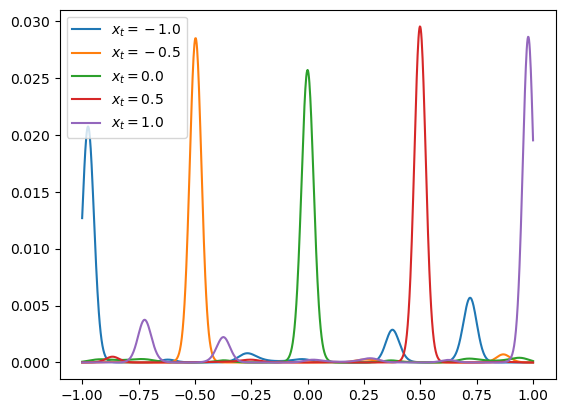

In [30]:
N = 1001
x_min, x_max = -1, 1

positions = torch.linspace(x_min, x_max, N, dtype=torch.float32, device=device)

true_positions = torch.tensor([-1, -0.5, 0, 0.5, 1], dtype=torch.float32, device=device)

true_activations = grid_cell_array(true_positions)
position_probabilities, position_expectations, most_probable_positions = decoder(true_activations, positions)
print(position_probabilities.shape)
print(true_positions)
print(position_expectations)
print(most_probable_positions)

for i, true_position in enumerate(true_positions):
    plt.plot(positions, position_probabilities[i].detach().numpy(), label=f"$x_t={true_position}$")

plt.legend()

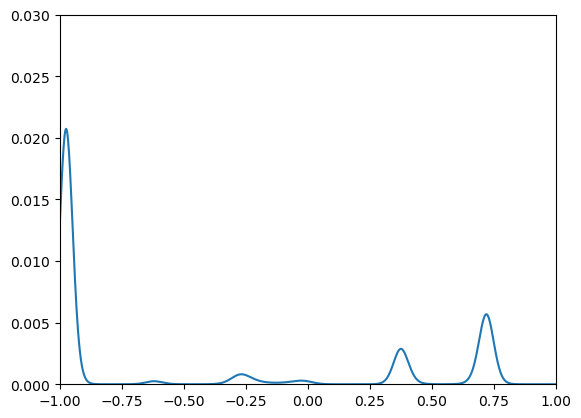

In [31]:
from matplotlib import animation


N = 1001
x_min, x_max = -1, 1

positions = torch.linspace(x_min, x_max, N, dtype=torch.float32, device=device)
target_positions = torch.linspace(x_min, x_max, 101, dtype=torch.float32, device=device)

    
fig, ax = plt.subplots()



# animation function. This is called sequentially
def drawframe(n):
    ax.clear()
    target_activations = grid_cell_array(target_positions[n])
    position_probabilities, _, _ = decoder(target_activations, positions)
    position_probabilities = position_probabilities.detach().numpy()
    ax.plot(positions, position_probabilities[0], label=f"$x_t={true_position}$")
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(0, 0.03)

    return ax,

anim = animation.FuncAnimation(fig, drawframe, frames=len(target_positions), interval=40, blit=False)

In [32]:
from IPython.display import HTML
HTML(anim.to_html5_video())


In [33]:
anim.save('../img/1d_positioning.gif', writer='imagemagick', fps=24)

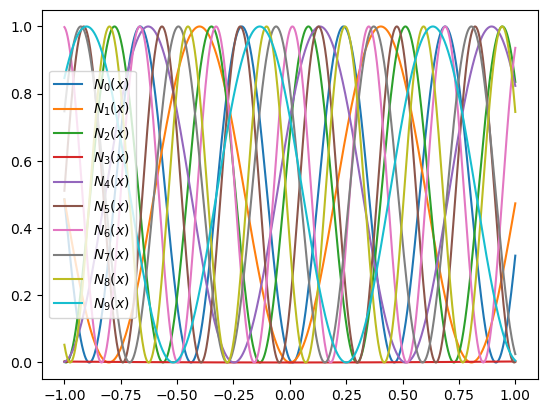

In [34]:
for i, neuron in enumerate(grid_cell_array.neurons):
    plt.plot(positions, neuron(positions).detach().numpy(), label=f"$N_{i}(x)$")

plt.legend()

torch.Size([5, 1001])
tensor([3.0000, 3.5000, 4.0000, 4.5000, 5.0000])
tensor([3.5010, 4.2863, 4.4186, 4.2679, 4.2336], grad_fn=<DivBackward0>)
tensor([3.0080, 4.3580, 4.7460, 4.4220, 4.3340])


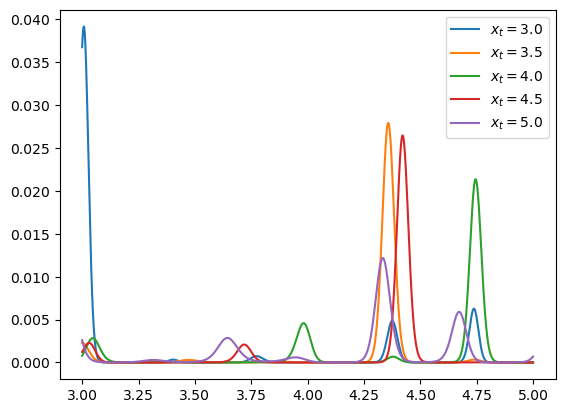

In [35]:
N = 1001
x_min, x_max = 3, 5

positions = torch.linspace(x_min, x_max, N, dtype=torch.float32, device=device)

true_positions = torch.tensor([3, 3.5, 4, 4.5, 5], dtype=torch.float32, device=device)

true_activations = grid_cell_array(true_positions)
position_probabilities, position_expectations, most_probable_positions = decoder(true_activations, positions)
print(position_probabilities.shape)
print(true_positions)
print(position_expectations)
print(most_probable_positions)

for i, true_position in enumerate(true_positions):
    plt.plot(positions, position_probabilities[i].detach().numpy(), label=f"$x_t={true_position}$")

plt.legend()

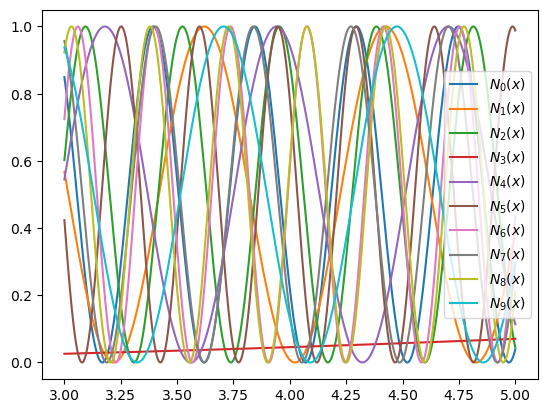

In [36]:
for i, neuron in enumerate(grid_cell_array.neurons):
    plt.plot(positions, neuron(positions).detach().numpy(), label=f"$N_{i}(x)$")

plt.legend()